In [49]:
#pip install 'qiskit>=1'
#pip install pylatexenc
# pip install qiskit_ibm_runtime

# Estimator lab exercise solution

When selecting a piece of chocolate candy from a box, the piece often meets our expectations. Sometimes after biting into the candy however, we find that the filling is not our favorite. This exercise leverages Qiskit Runtime and a Variational Quantum Eigensolver (VQE) to assemble a box of chocolates that hopefully meets our expectations. It uses the Qiskit Runtime Estimator to calculate the expectation values for combinations of candies in a box, and uses a Qiskit Runtime session to facilitate running a VQE algorithm to find the highest expectation value. This program draws upon code from an example that experimental physicist & IBM Quantum researcher Nick Bronn created for the [Coding with Qiskit Runtime video series](https://www.youtube.com/playlist?list=PLOFEBzvs-VvqAC8DnVoLOzg2bKE4C7ARM), specifically in [Episode 05 Primitives & Sessions](https://youtu.be/yxuH8eb4MS4?si=e3trSORNjooWlQXu).

### 1. Initialize the account

In [50]:
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Pauli, SparsePauliOp

 

In [51]:
import matplotlib.pyplot as plt
import numpy as np

In [52]:
from qiskit_algorithms.optimizers import SPSA
from qiskit.circuit.library import EfficientSU2
from qiskit_ibm_runtime import Session, Estimator

In [53]:
from qiskit_ibm_runtime import Options, Session, QiskitRuntimeService


TODO: which backends do we want to use?

In [54]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

### 2. Create an operator

There are three pieces of chocolate candy in a box. Each piece can either have a vanilla center or a raspberry center. The user likes vanilla centers but dislikes raspberry centers, so we'll say that picking a vanilla it is worth 1 point, but picking a raspberry it is worth -1 point. To model this as an operator, we'll create three Pauli operators and sum them together. Each piece of candy in the box is represented by a qubit, and each of these Pauli's contain expectation values for their corresponding position in the box. Summing them together results in the diagonal of the operator containing eigenvalues that represent expectation values for all eight possible combinations of candy in the box. 

In [55]:
# Create an operator by summing together three Pauli operators 
choc_op = SparsePauliOp(['ZII', 'IZI', 'IIZ'])

print(choc_op.to_matrix())


[[ 3.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -3.+0.j]]


### 3. Setup and run a VQE algorithm

#### a. Create a parameterized circuit to serve as the ansatz

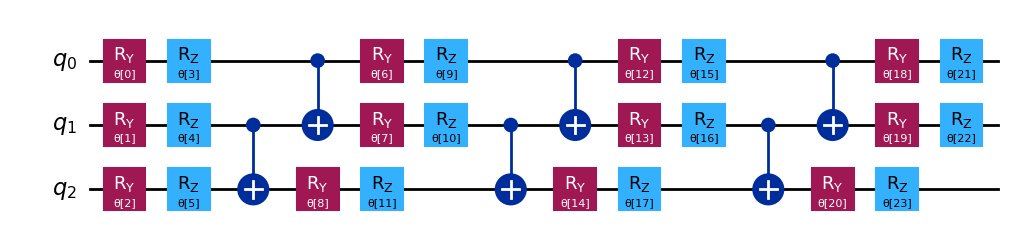

In [56]:
ansatz = EfficientSU2(3)
ansatz.decompose().draw('mpl')

#### b. Tweak some Qiskit Runtime options if desired

TODO: requires update - what can we tweat in qiskit 1.0?

In [57]:
options = Options()
options.resilience_level = 1
options.execution.shots = 1024


#### c. Implement VQE leveraging Session, Estimator and an optimizer

In [60]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager       
pm = generate_preset_pass_manager(optimization_level=1, target=backend.target)           


In [62]:
with Session(backend=backend, max_time="1h") as session:
    estimator = Estimator(options=options)
    
    # Define a callback to print values in each iteration of the optimizer
    callback = lambda nfev, params, fval, step, acc: print(f'Evaluation {nfev}: {fval}')
    optimizer = SPSA(callback=callback, maxiter=800)

    #NEW
    isa_circuits = pm.run(ansatz)    

    # Define a cost function, flipping the sign so that the optimizer maximizes the expectation value
    cost_func = lambda params: estimator.run(isa_circuits, choc_op, parameter_values=params).result().values[0] * -1
    result = optimizer.minimize(cost_func, x0=np.zeros(isa_circuits.num_parameters))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:156: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:08:46,798: An error occurred while streaming results from the server for job co0mifghn4v66uia78m0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Vers

Evaluation 3: -1.330078125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:24:46,734: An error occurred while streaming results from the server for job co0mpvg4iheo8844oh9g:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 6: -1.31640625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:25:41,337: An error occurred while streaming results from the server for job co0mqd84iheo8844ohn0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 9: 0.8984375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:26:35,568: An error occurred while streaming results from the server for job co0mqqoic362l6k5vg40:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 12: -0.115234375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:27:28,820: An error occurred while streaming results from the server for job co0mr84madoqp48hck60:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 15: 0.408203125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:28:31,770: An error occurred while streaming results from the server for job co0mrm04iheo8844ojhg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 18: -0.06640625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:34:39,627: An error occurred while streaming results from the server for job co0mujt8qna24pr9sljg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 21: 0.66015625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:35:35,215: An error occurred while streaming results from the server for job co0mv1g4iheo8844opo0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 24: 0.103515625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:36:30,343: An error occurred while streaming results from the server for job co0mvfg4iheo8844oqk0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 27: -0.1953125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:37:25,745: An error occurred while streaming results from the server for job co0mvt8ic362l6k5vov0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 30: 1.525390625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:38:21,529: An error occurred while streaming results from the server for job co0n0bd8qna24pr9so6g:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 33: 0.626953125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:39:14,841: An error occurred while streaming results from the server for job co0n0ol8qna24pr9sp00:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 36: 0.724609375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:40:10,017: An error occurred while streaming results from the server for job co0n16ghn4v66uia82o0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 39: -0.380859375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:41:03,886: An error occurred while streaming results from the server for job co0n1john4v66uia84sg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 42: 0.43359375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:41:57,880: An error occurred while streaming results from the server for job co0n21d8qna24pr9ssqg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 45: -0.0390625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:42:51,088: An error occurred while streaming results from the server for job co0n2esmadoqp48hd2a0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 48: -0.4375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:43:45,158: An error occurred while streaming results from the server for job co0n2s84iheo8844p21g:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 51: 0.591796875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:54:18,422: An error occurred while streaming results from the server for job co0n7qg4iheo8844pb0g:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 54: 0.447265625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:55:12,429: An error occurred while streaming results from the server for job co0n880hn4v66uia8gf0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 57: 0.41015625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:56:06,646: An error occurred while streaming results from the server for job co0n8lg4iheo8844pc2g:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 60: -0.056640625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:57:00,216: An error occurred while streaming results from the server for job co0n930hn4v66uia8hbg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 63: -0.091796875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:57:53,778: An error occurred while streaming results from the server for job co0n9gd8qna24pr9t870:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 66: -0.15234375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:58:48,953: An error occurred while streaming results from the server for job co0n9u8ic362l6k60ai0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 69: -0.18359375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 12:59:42,615: An error occurred while streaming results from the server for job co0nabg4iheo8844pefg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 72: -0.318359375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:00:36,156: An error occurred while streaming results from the server for job co0nap58qna24pr9tb70:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 75: -0.25


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:01:29,348: An error occurred while streaming results from the server for job co0nb6d8qna24pr9tcl0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 78: -0.54296875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:02:22,568: An error occurred while streaming results from the server for job co0nbjkmadoqp48hdhdg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 81: -0.55859375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:03:15,736: An error occurred while streaming results from the server for job co0nc0v5979r5og7jdo0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 84: -0.58203125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:04:10,121: An error occurred while streaming results from the server for job co0ncegic362l6k60glg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 87: -0.3984375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:15:20,104: An error occurred while streaming results from the server for job co0nhm4madoqp48hdvkg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 90: -0.423828125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:16:13,679: An error occurred while streaming results from the server for job co0ni38hn4v66uia95fg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 93: -0.501953125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:17:07,454: An error occurred while streaming results from the server for job co0nigo4iheo8844q21g:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 96: 0.041015625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:18:01,576: An error occurred while streaming results from the server for job co0niu84iheo8844q30g:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 99: -0.955078125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:18:56,189: An error occurred while streaming results from the server for job co0njc04iheo8844q420:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 102: -0.115234375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:19:51,129: An error occurred while streaming results from the server for job co0njpoic362l6k611m0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 105: -0.73828125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:20:46,078: An error occurred while streaming results from the server for job co0nk7l8qna24pr9u1r0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 108: 0.890625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:21:40,742: An error occurred while streaming results from the server for job co0nkl04iheo8844q8n0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 111: 0.603515625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:22:34,882: An error occurred while streaming results from the server for job co0nl2ghn4v66uia9deg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 114: -0.052734375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:23:28,751: An error occurred while streaming results from the server for job co0nlg0hn4v66uia9e80:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 117: -0.01171875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:24:22,230: An error occurred while streaming results from the server for job co0nltkmadoqp48he8ng:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 120: 0.494140625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:25:15,674: An error occurred while streaming results from the server for job co0nmav5979r5og7k620:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 123: 0.404296875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:26:10,614: An error occurred while streaming results from the server for job co0nmon5979r5og7k6pg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 126: 0.298828125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:27:05,659: An error occurred while streaming results from the server for job co0nn68ic362l6k619eg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 129: 0.283203125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:28:00,327: An error occurred while streaming results from the server for job co0nnk0ic362l6k61aeg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 132: 0.35546875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:28:55,230: An error occurred while streaming results from the server for job co0no1o4iheo8844qfo0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 135: -0.458984375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:29:50,292: An error occurred while streaming results from the server for job co0nofkmadoqp48hee30:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 138: -0.775390625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:30:45,489: An error occurred while streaming results from the server for job co0not8hn4v66uia9mcg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 141: -0.759765625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:31:41,374: An error occurred while streaming results from the server for job co0npbcmadoqp48hehp0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 144: -0.759765625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:32:35,084: An error occurred while streaming results from the server for job co0npon5979r5og7kfg0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 147: -0.7421875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:33:29,473: An error occurred while streaming results from the server for job co0nq684iheo8844qmt0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 150: -0.994140625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:34:23,613: An error occurred while streaming results from the server for job co0nqjt8qna24pr9uh90:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 153: -2.677734375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:35:17,457: An error occurred while streaming results from the server for job co0nr1d8qna24pr9uidg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 156: -0.841796875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:36:11,279: An error occurred while streaming results from the server for job co0nreohn4v66uia9tsg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 159: 0.1953125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:39:34,032: An error occurred while streaming results from the server for job co0nsn0hn4v66uiaa0r0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 162: -1.03125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:41:38,277: An error occurred while streaming results from the server for job co0nu0gic362l6k61ukg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 165: -0.783203125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:42:33,020: An error occurred while streaming results from the server for job co0nue58qna24pr9uu30:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 168: -0.138671875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:43:28,348: An error occurred while streaming results from the server for job co0nus4madoqp48hf2k0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 171: -0.646484375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:44:23,865: An error occurred while streaming results from the server for job co0nv9ohn4v66uiaa9f0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 174: 0.26171875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:45:18,421: An error occurred while streaming results from the server for job co0nvnkmadoqp48hf58g:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 177: 0.134765625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:46:11,655: An error occurred while streaming results from the server for job co0o04smadoqp48hf6o0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 180: -0.66015625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:47:05,962: An error occurred while streaming results from the server for job co0o0i84iheo8844ralg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 183: -0.505859375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:47:59,883: An error occurred while streaming results from the server for job co0o0vv5979r5og7l77g:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 186: -1.39453125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:48:54,465: An error occurred while streaming results from the server for job co0o1dl8qna24pr9v7p0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 189: 0.8515625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:49:48,073: An error occurred while streaming results from the server for job co0o1r0ic362l6k62aig:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 192: -0.521484375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:50:41,443: An error occurred while streaming results from the server for job co0o28cmadoqp48hfea0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 195: -0.50390625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:51:35,088: An error occurred while streaming results from the server for job co0o2lt8qna24pr9vcfg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 198: 0.869140625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:52:29,473: An error occurred while streaming results from the server for job co0o338hn4v66uiaam80:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 201: 0.421875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:53:23,426: An error occurred while streaming results from the server for job co0o3gsmadoqp48hfis0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 204: 0.228515625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:54:17,583: An error occurred while streaming results from the server for job co0o3u84iheo8844rm9g:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 207: -0.318359375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:55:12,272: An error occurred while streaming results from the server for job co0o4c58qna24pr9vhh0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 210: -0.23828125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:56:05,866: An error occurred while streaming results from the server for job co0o4p8ic362l6k62ji0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 213: -0.685546875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:57:00,274: An error occurred while streaming results from the server for job co0o5758qna24pr9vj30:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 216: -0.63671875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:57:53,751: An error occurred while streaming results from the server for job co0o5k84iheo8844rp90:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 219: -0.626953125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:58:47,347: An error occurred while streaming results from the server for job co0o61oic362l6k62mc0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 222: -0.470703125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 13:59:41,387: An error occurred while streaming results from the server for job co0o6fd8qna24pr9vmcg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 225: 0.482421875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:00:35,237: An error occurred while streaming results from the server for job co0o6soic362l6k62q40:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 228: 0.41015625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:01:29,242: An error occurred while streaming results from the server for job co0o7a84iheo8844rvjg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 231: 0.2734375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:02:22,005: An error occurred while streaming results from the server for job co0o7ngic362l6k62sl0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 234: 0.375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:03:15,842: An error occurred while streaming results from the server for job co0o84smadoqp48hfvbg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 237: 0.509765625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:07:14,011: An error occurred while streaming results from the server for job co0o8it8qna24pr9vtv0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 240: -1.037109375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:08:16,099: An error occurred while streaming results from the server for job co0oafoic362l6k634l0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 243: -0.861328125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:09:10,620: An error occurred while streaming results from the server for job co0oatl8qna24pra04hg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 246: -0.68359375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:10:04,754: An error occurred while streaming results from the server for job co0obb04iheo8844sc0g:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 249: -0.716796875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:10:58,917: An error occurred while streaming results from the server for job co0obooic362l6k63akg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 252: -0.638671875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:11:54,602: An error occurred while streaming results from the server for job co0oc6gic362l6k63c30:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 255: -0.615234375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:12:49,254: An error occurred while streaming results from the server for job co0ockf5979r5og7mdk0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 258: -0.76171875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:13:43,981: An error occurred while streaming results from the server for job co0od1ohn4v66uiabkhg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 261: -1.203125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:14:38,659: An error occurred while streaming results from the server for job co0odfgic362l6k63ghg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 264: -1.73828125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:15:35,137: An error occurred while streaming results from the server for job co0odtghn4v66uiabnl0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 267: -0.466796875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:16:29,385: An error occurred while streaming results from the server for job co0oebcmadoqp48hglag:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 270: -0.150390625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:17:23,114: An error occurred while streaming results from the server for job co0oeooic362l6k63kig:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 273: 0.80078125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:18:17,112: An error occurred while streaming results from the server for job co0of684iheo8844sq90:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 276: 0.798828125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:19:10,959: An error occurred while streaming results from the server for job co0ofjsmadoqp48hgou0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 279: -0.072265625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:20:06,818: An error occurred while streaming results from the server for job co0og1ghn4v66uiabtrg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 282: -0.333984375


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:21:00,839: An error occurred while streaming results from the server for job co0ogf04iheo8844svu0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 285: -0.3828125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:21:54,858: An error occurred while streaming results from the server for job co0ogskmadoqp48hgul0:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 288: -0.5390625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:22:51,094: An error occurred while streaming results from the server for job co0ohaoic362l6k63ttg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 291: -0.703125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:23:44,960: An error occurred while streaming results from the server for job co0oho0ic362l6k63vbg:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 294: -0.373046875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:24:38,292: An error occurred while streaming results from the server for job co0oi5l8qna24pra0u40:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 297: -0.669921875


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:25:31,770: An error occurred while streaming results from the server for job co0oiio4iheo8844t680:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

Evaluation 300: -1.08203125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:879: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)
base_runtime_job._start_websocket_client:WARNING:2024-03-25 14:44:04,484: An error occurred while streaming results from the server for job co0oj0gic362l6k64330:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 311, in _start_websocket_client
    self._ws_client.job_results()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Library/Frameworks/Pyth

IBMRuntimeError: 'Failed to run program: "HTTPSConnectionPool(host=\'api.quantum.ibm.com\', port=443): Read timed out. (read timeout=900)"'

#### d. Print and plot the results

In [63]:
print(result)

NameError: name 'result' is not defined

In [64]:
import matplotlib.pyplot as plt

jobs = service.jobs(session_id=session.session_id, limit=None)
expectations = [job.result().values[0] for job in jobs if job.done()][::-1]

plt.plot(range(len(expectations)), expectations, label='backend')
plt.plot(range(len(expectations)), [3.0]*len(expectations), ls='--', label='exact')
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Expectation', fontsize=16)
plt.legend(loc='lower right')

AttributeError: 'SamplerResult' object has no attribute 'values'